# Exercise 3: Attacks and Defenses
## Part 2: Practice


You can use code and models which are publicly available, please clearly reference such sources. It might be a good idea to start with the examples given in the practical part of the lecture (available at https://jgoepfert.pages. ub.uni-bielefeld.de/talk-deep-learning ) or you might want to resort to popular toolboxes such as https://adversarial-robustness-toolbox.readthedocs.io/en/ latest/. Please give a link to your code, and please describe the experiments and results of your approach in a pdf which is well structured (e.g. modeling/training parameters/training/results/interpretation, use itemize, keywords are fine) and enables reproducability as well as easy access to your main results. Please use at most one page for both practical parts together including graphs and images.

### 1. Part
Take the model for the FashionMNIST data from the first sheet. Perform targeted and untargeted attacks for different sampled examples and classes and report, whether some attacks are harder to achieve than others (depending e.g. in classes, location of data, ...) and why – you might want to visualize the classes using tSNE or UMAP for this purpose or even use DeepView.



> 1.1 Targeted Attacks have the goal of misguiding a model to a particular class and not the true class


  *   L-BFGS: 'find an adversarial example whoch could be classified as a certain class and is close to the clean image' (https://arxiv.org/pdf/2005.06149v1.pdf)
  *   Carlini and Wagner attcks:
  trie to solve the same problem as L-BFGS with finding the minim dstorted perturbation so that the new picture has a larger score for the target class than for any other class. Therefore the target class will be predicted.




> 1.2 Untargeted Attacks have the goal of  misguiding a model away from the true class to any other class


  *   FGSM: find a perturbed sample that can fool the network with a small change
  (https://arxiv.org/pdf/2005.06149v1.pdf)
  *   DeepFool: 'Deepfool attack aims to find a shortest path to let the data point x go across the decision boundary. '(https://arxiv.org/pdf/2005.06149v1.pdf)






## 1.1 Visualize FashionMNIST data with UMAP
https://umap-learn.readthedocs.io/en/latest/supervised.html#umap-on-fashion-mnist

In [ ]:
!pip install umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=07eaf6723efaf12eaddc9eb92864a44280705c440d41a8b6ce15f64503245ceb
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 30.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=0b4e55c92a629e22f0d32cc0ce80701b8419ced45e3a1aab34a669dd26dddd47
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=38ff136f64d912806119335bd5df748a681c005c7d313d81a086

In [ ]:
from umap import UMAP
import umap
import sklearn.datasets

fmnist = sklearn.datasets.fetch_openml('Fashion-MNIST')
classes = ['0: T-shirt/top','1: Trouser','2: Pullover','3: Dress','4: Coat','5: Sandal','6: Shirt','7: Sneaker','8: Bag','9: Ankle boot']
targets = np.array(fmnist.target,dtype=int)
mapper = UMAP().fit_transform(fmnist.data, y=targets)

Text(0.5, 1.0, 'Fashion MNIST Embedded via UMAP')

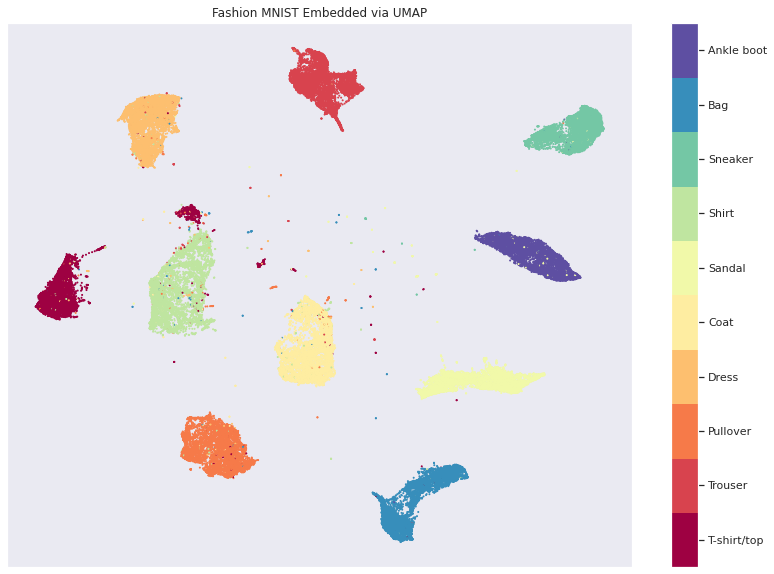

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.T, c=targets ,s=1, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP')


## 1.2 Importing and train model from Exercise 01

In [1]:
#import 
import os.path

import numpy as np	
import math
import matplotlib.pyplot as plt

import torch.utils.data
import torchvision.utils
from torch import nn, optim
from torch.nn import functional
from torchvision import datasets, transforms
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import skimage.data
import skimage.filters
import skimage.io
 
try:
    import seaborn as sns
    sns.set()
except:
    pass

import random
import time

In [2]:
# Select GPU if available.
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

# Seed
torch.manual_seed(42)

# Prepare training and test data.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_data_loader = torch.utils.data.DataLoader(training_data, batch_size=64)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [3]:
# Fashion Network from the first exercise: Adam optimizer with learning rate 1e-3 and the CrossEntropyLoss
# Define network.
class FashionNetwork(nn.Module):
    def __init__(self):
        super(FashionNetwork, self).__init__()
    
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU())
        
        self.flatten = nn.Flatten()
        
        self.layer4 = nn.Sequential(
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU()
        )
        
        self.layer5 = nn.Sequential(
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

   

def train_loop(model, data_loader, loss_function, optimizer):
    total_loss = 0.0
    
    for batch, (data, labels) in enumerate(data_loader):
        # Feed data through network and compute loss.
        prediction = model(data)
        loss = loss_function(prediction, labels)
        total_loss += loss
 
        # Zero gradients.
        optimizer.zero_grad()
 
        # Perform backpropagation and accumulate gradients.
        loss.backward()
 
        # Update network parameters.
        optimizer.step()
    
    return total_loss / len(data_loader)

def test_loop(data_loader, model, loss_function):
    n_samples = len(data_loader.dataset)
    n_batches = len(data_loader)
    loss, n_correct = 0, 0
 
    with torch.no_grad():
        for data, labels in data_loader:
            # Feed data through network and accumulate loss.
            prediction = model(data)
            loss += loss_function(
                prediction, labels
            ).item()
            n_correct += (
                (prediction.argmax(1) == labels)
                .type(torch.float)
                .sum()
                .item()
            )
 
    print(
        f"Test Accuracy: {n_correct / n_samples:.2%}, "
        f"Test Loss: {loss / n_batches:.4}"
    )
    return loss / n_batches

def train(model, train_data, test_data, optimizer,loss_fn, n_epochs=10): #TODO:change epochs back to 10
    train_history = np.zeros(n_epochs)
    test_history = np.zeros(n_epochs)
      
    for t in range(n_epochs):
        print(f"Epoch {t + 1:02}", end=" ", flush=True)
        train_history[t] = train_loop(model, train_data, loss_fn, optimizer)
        test_history[t] = test_loop(test_data, model, loss_fn)
    
    return model, train_history, test_history



In [16]:
#Model with Adam Optimizer
model = FashionNetwork()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn=nn.CrossEntropyLoss()

model, train_history, test_history = train(model, train_data_loader, test_data_loader, optimizer, loss_fn)

Epoch 01 Test Accuracy: 78.96%, Test Loss: 1.673
Epoch 02 Test Accuracy: 82.32%, Test Loss: 1.639
Epoch 03 Test Accuracy: 84.68%, Test Loss: 1.615
Epoch 04 Test Accuracy: 86.27%, Test Loss: 1.598
Epoch 05 Test Accuracy: 87.33%, Test Loss: 1.587
Epoch 06 Test Accuracy: 87.66%, Test Loss: 1.585
Epoch 07 Test Accuracy: 86.81%, Test Loss: 1.592
Epoch 08 Test Accuracy: 88.00%, Test Loss: 1.58
Epoch 09 Test Accuracy: 88.78%, Test Loss: 1.573
Epoch 10 Test Accuracy: 88.79%, Test Loss: 1.572


In [4]:
#Model with SGD Optimizer
model = FashionNetwork()
optimizer=torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn=nn.CrossEntropyLoss()

model, train_history_sgd, test_history_sgd = train(model, train_data_loader, test_data_loader, optimizer, loss_fn)

Epoch 01 Test Accuracy: 17.44%, Test Loss: 2.302
Epoch 02 Test Accuracy: 23.53%, Test Loss: 2.301
Epoch 03 Test Accuracy: 32.84%, Test Loss: 2.3
Epoch 04 Test Accuracy: 46.89%, Test Loss: 2.295
Epoch 05 Test Accuracy: 20.67%, Test Loss: 2.244
Epoch 06 Test Accuracy: 61.26%, Test Loss: 1.892
Epoch 07 Test Accuracy: 67.01%, Test Loss: 1.801
Epoch 08 Test Accuracy: 69.33%, Test Loss: 1.773
Epoch 09 Test Accuracy: 70.78%, Test Loss: 1.759
Epoch 10 Test Accuracy: 71.19%, Test Loss: 1.752


## 1.3 Targetet attacks

Looking at the UMAP you can assume that targeted attacks bewteen similar looking items such as Shirt,Coats, Dresses, Pullovers and T-Shirts will be easier than transforming those to Ankle Boots, Bags, Sneakers, Sandals and Trouser.  Respectively classes from the categorie shoes are quite similiar (Sandals, Sneaker, Ankle Boots).

In [5]:
!git clone https://github.com/DSE-MSU/DeepRobust.git
!pip install deeprobust 


fatal: destination path 'DeepRobust' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install ipdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Code below if from the following github: https://github.com/wenqifan03/RobustTorch/blob/master/image/attack/lbfgs.py

In [13]:
import torch
import torch.nn as nn
import scipy.optimize as so
import numpy as np
import torch.nn.functional as F #233

from deeprobust.image.attack.base_attack import BaseAttack
 
class LBFGS(BaseAttack):

    def __init__(self, model, target_label, device = 'cuda' ):  
        super(LBFGS, self).__init__(model, device)
        self.target_label = target_label

    def generate(self, image, label, **kwargs):
        assert self.check_type_device(image, label)
        assert self.parse_params(**kwargs)
        return optimize(self.model, 
                        self.image, 
                        self.label, 
                        self.target_label, 
                        self.bounds, 
                        self.epsilon, 
                        self.maxiter, 
                        self.class_num)

    def parse_params(self,
                     clip_max,
                     clip_min,
                     class_num,
                     epsilon = 1e-5,  #step of finding initial c
                     maxiter = 20,    #maximum of iteration in lbfgs optimization  
                     ):
        self.epsilon = epsilon
        self.maxiter = maxiter 
        self.class_num = class_num
        self.bounds = (clip_min, clip_max)
        return True

def optimize(model, image, label, target_label, bounds, epsilon, maxiter, class_num):
    x_t = image
    x0 = image[0].detach().numpy()
    min_, max_ = bounds
        
        
    target_dist = torch.tensor(target_label)
    target_dist = target_dist.unsqueeze_(0).long()
       

    # store the shape for later and operate on the flattened input
        
    shape = x0.shape
    dtype = x0.dtype
    x0 = x0.flatten().astype(np.float64)

    n = len(x0)
    bounds = [(min_, max_)] * n

    def distance(x,y):
        # calculate the distance
        x = torch.from_numpy(x).double()
        y = torch.from_numpy(y).double()

        dist_squ = torch.norm(x - y)
        return dist_squ **2

    def loss(x, c):
        #calculate the target function 
        v1 = distance(x0,x)
            
        x = torch.tensor(x.astype(dtype).reshape(shape))
        x = x.unsqueeze_(0).float()

        predict = model(x)
        v2 = F.nll_loss(predict, target_dist)
            
        v = c * v1 + v2
        #print(v)
        return np.float64(v)

    def pending_attack(target_model, adv_exp, target_label):
        # pending if the attack success
        adv_exp = adv_exp.reshape(shape).astype(dtype)
        adv_exp = torch.from_numpy(adv_exp)
        adv_exp = adv_exp.unsqueeze_(0).float()

        predict1 = target_model(adv_exp)
        label = predict1.argmax(dim=1, keepdim=True)
        print('label ',label)
        print('target label ', target_label)
        if label == target_label:
            print('True')
            return True
        else:
            return False

    def lbfgs_b(c):

        #initial the variables
        approx_grad_eps = (max_ - min_) / 100
        print('in lbfgs_b:', 'c =', c)

        #start optimization
        optimize_output, f, d = so.fmin_l_bfgs_b(
                loss,
                x0,
                args=(c,),
                approx_grad = True,
                bounds = bounds,
                m = 15,
                maxiter = maxiter,
                factr = 1e10,  #optimization accuracy
                maxls = 5,      
                epsilon = approx_grad_eps)
        print('finish optimization')
          
        # LBFGS-B does not always exactly respect the boundaries
        if np.amax(optimize_output) > max_ or np.amin(optimize_output) < min_:   # pragma: no coverage
            logging.info('Input out of bounds (min, max = {}, {}). Performing manual clip.'.format(
                    np.amin(optimize_output), np.amax(optimize_output)))
                
            optimize_output = np.clip(optimize_output, min_, max_)

        #optimize_output = optimize_output.reshape(shape).astype(dtype)
        #test_input = torch.from_numpy(optimize_output)
        #print(test_input)
        #test_input = test_input.unsqueeze_(0).float()
        is_adversarial = pending_attack(target_model = model, adv_exp = optimize_output, target_label = target_label)
        return optimize_output, is_adversarial

    #x_new, isadv = lbfgs_b(0)


    # finding initial c
    c = epsilon
    print('finding initial c:')

    for i in range(maxiter):
        c = 2 * c
        x_new, is_adversarial = lbfgs_b(c)
        if is_adversarial == True:#False:
            break
        
    print('start binary search:')
    if is_adversarial == False:#True:  # pragma: no cover
        print('Could not find an adversarial; maybe the model returns wrong gradients')
        return
    print('c_high:',c)

    # binary search
    c_low = 0
    c_high = c
    while c_high - c_low >= epsilon:
        print(c_high,' ',c_low)
        c_half = (c_low + c_high) / 2
        x_new, is_adversarial = lbfgs_b(c_half)
          
        if is_adversarial:
            c_low = c_half
        else:
            c_high = c_half
        
    x_new, is_adversarial = lbfgs_b(c_low)
    
    
      
    dis = distance(x_new, x0)
    mintargetfunc = loss(x_new, c_low)

    x_new = x_new.astype(dtype)
    x_new = x_new.reshape(shape)
    x_new = torch.from_numpy(x_new)
        
    return x_new, dis, mintargetfunc, c_low



In [14]:
#L- BFGS

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F #233
import torch.optim as optim
from torchvision import datasets,models,transforms
from PIL import Image

#from lbfgs import LBFGS
import deeprobust
from deeprobust.image.netmodels.CNN import Net
from deeprobust.image.config import attack_params
import ipdb

def lbfgs_target(model,image,label,target_class):
  #load model
  model = model
  #model.load_state_dict(torch.load(model), map_location = torch.device('cpu'))
  model.eval()
  ## Set Data
  xx = image 
  yy = label

  predict0 = model(xx)
  predict0= predict0.argmax(dim=1, keepdim=True)

  attack_param = {
      'epsilon': 1e-5,
      'maxiter': 20,
      'clip_max': 1,
      'clip_min': 0,
      'class_num': 10
      }

  attack = LBFGS(model, target_class,device='cpu') #targetlabel=target_Class is new
 
  try:
    AdvExArray, dis, mintargetfunc, c_low =  attack.generate(xx, yy,  **attack_param) #target_label = target_class,
    AdvExArray = torch.reshape(AdvExArray,(1,1,28, 28)) #LBFGS return shape (1,28,28), need to shape it to (1,1,28,28) otherwise rpedict can't work with it
  except:
    AdvExArray = None

  # predict
  try:
    predict1 = model(AdvExArray).cpu().detach()
    predict1 = torch.softmax(predict1,dim=-1)#confidence in prediction
  except:
    predict1= None
  
  predict0 = model(xx).cpu().detach()
  predict0 = torch.softmax(predict0,dim=-1)

  return AdvExArray, predict0, predict1



## 1.4 Untargeted Attacks

In [7]:
#FGSM
from deeprobust.image.attack.fgsm import FGSM
from deeprobust.image.netmodels.CNN import Net
from deeprobust.image.config import attack_params
from deeprobust.image.utils import download_model

def fgsm_untargeted(model,image,label):
  
  # load model
  model = model
  model.eval()

  ## load date
  xx = image 
  yy = label.int() 


  F1 = FGSM(model, device = "cpu")       ### or cuda
  attack_param = {'epsilon' :0.2,
                     'order' : np.inf,
                     'clip_max' : 1,
                     'clip_min' : 0}

  AdvExArray = F1.generate(xx, yy, **attack_param)

  # predict
  predict1 = model(AdvExArray).cpu().detach()
  predict0 = model(xx).cpu().detach()
  
  predict1 = torch.softmax(predict1,dim=-1)#confidence in prediction
  predict0 = torch.softmax(predict0,dim=-1)


  return AdvExArray, predict0, predict1


In [8]:
#deepfool
from deeprobust.image.attack.deepfool import DeepFool
import deeprobust.image.netmodels.resnet as resnet

def deep_fool_untargeted_attack(model,image,label):
 
  # load model
  model = model
  model.eval()

  # load dataset
  X = image 
  Y = label.int()
  
  # choose attack example
  attack_param = {'num_classes' : 10,
                      'overshoot' : 0.02,
                      'max_iteration' : 1000000}
  # run deepfool attack
  adversary = DeepFool(model,device='cpu')
  AdvExArray = adversary.generate(X, Y,**attack_param)

  # predict
  predict1 = model(AdvExArray).cpu().detach()
  predict0 = model(X).cpu().detach()
  
  predict1 = torch.softmax(predict1,dim=-1)#confidence in prediction
  predict0 = torch.softmax(predict0,dim=-1)

  return AdvExArray, predict0, predict1

#img_fake, predict0, predict1,data_idx = deep_fool_untargeted_attack(model, 5)

In [9]:
#exercise
def image_to_tensor(input_array):
    # Normalize input.
    input_array = input_array - [0.485, 0.456, 0.406]
    input_array = input_array / [0.229, 0.224, 0.225]
 
    # Turn from (width, height, channel) into (batch, channel, width, height) and convert to tensor.
    input_tensor = torch.Tensor((input_array.transpose([2, 0, 1]))[None, ...])
 
    return input_tensor

In [10]:
#exercise
def tensor_to_image(tensor):
    # Turn from (batch, channel, width, height) tensor into (width, height, channel) array.
    array = tensor[0].detach().numpy().transpose([1, 2, 0])
 
    # Denormalize.
    array = array * [0.229, 0.224, 0.225]
    array = array + [0.485, 0.456, 0.406]
 
    # Clip.
    np.clip(array, 0.0, 1.0, out=array)
 
    return array

def tensor_to_image_lbfgs(tensor):
    # Turn from (batch, channel, width, height) tensor into (width, height, channel) array.
    array = tensor.detach().numpy().transpose([1, 2, 0])
 
    # Denormalize.
    array = array * [0.229, 0.224, 0.225]
    array = array + [0.485, 0.456, 0.406]
 
    # Clip.
    np.clip(array, 0.0, 1.0, out=array)
 
    return array

In [11]:
label_names = {0:'T-shirt/top',1:	'Trouser',2: 'Pullover',3:	'Dress',4: 'Coat',5: 'Sandal',6: 'Shirt',7:	'Sneaker',8:	'Bag',9:	'Ankle boot'}

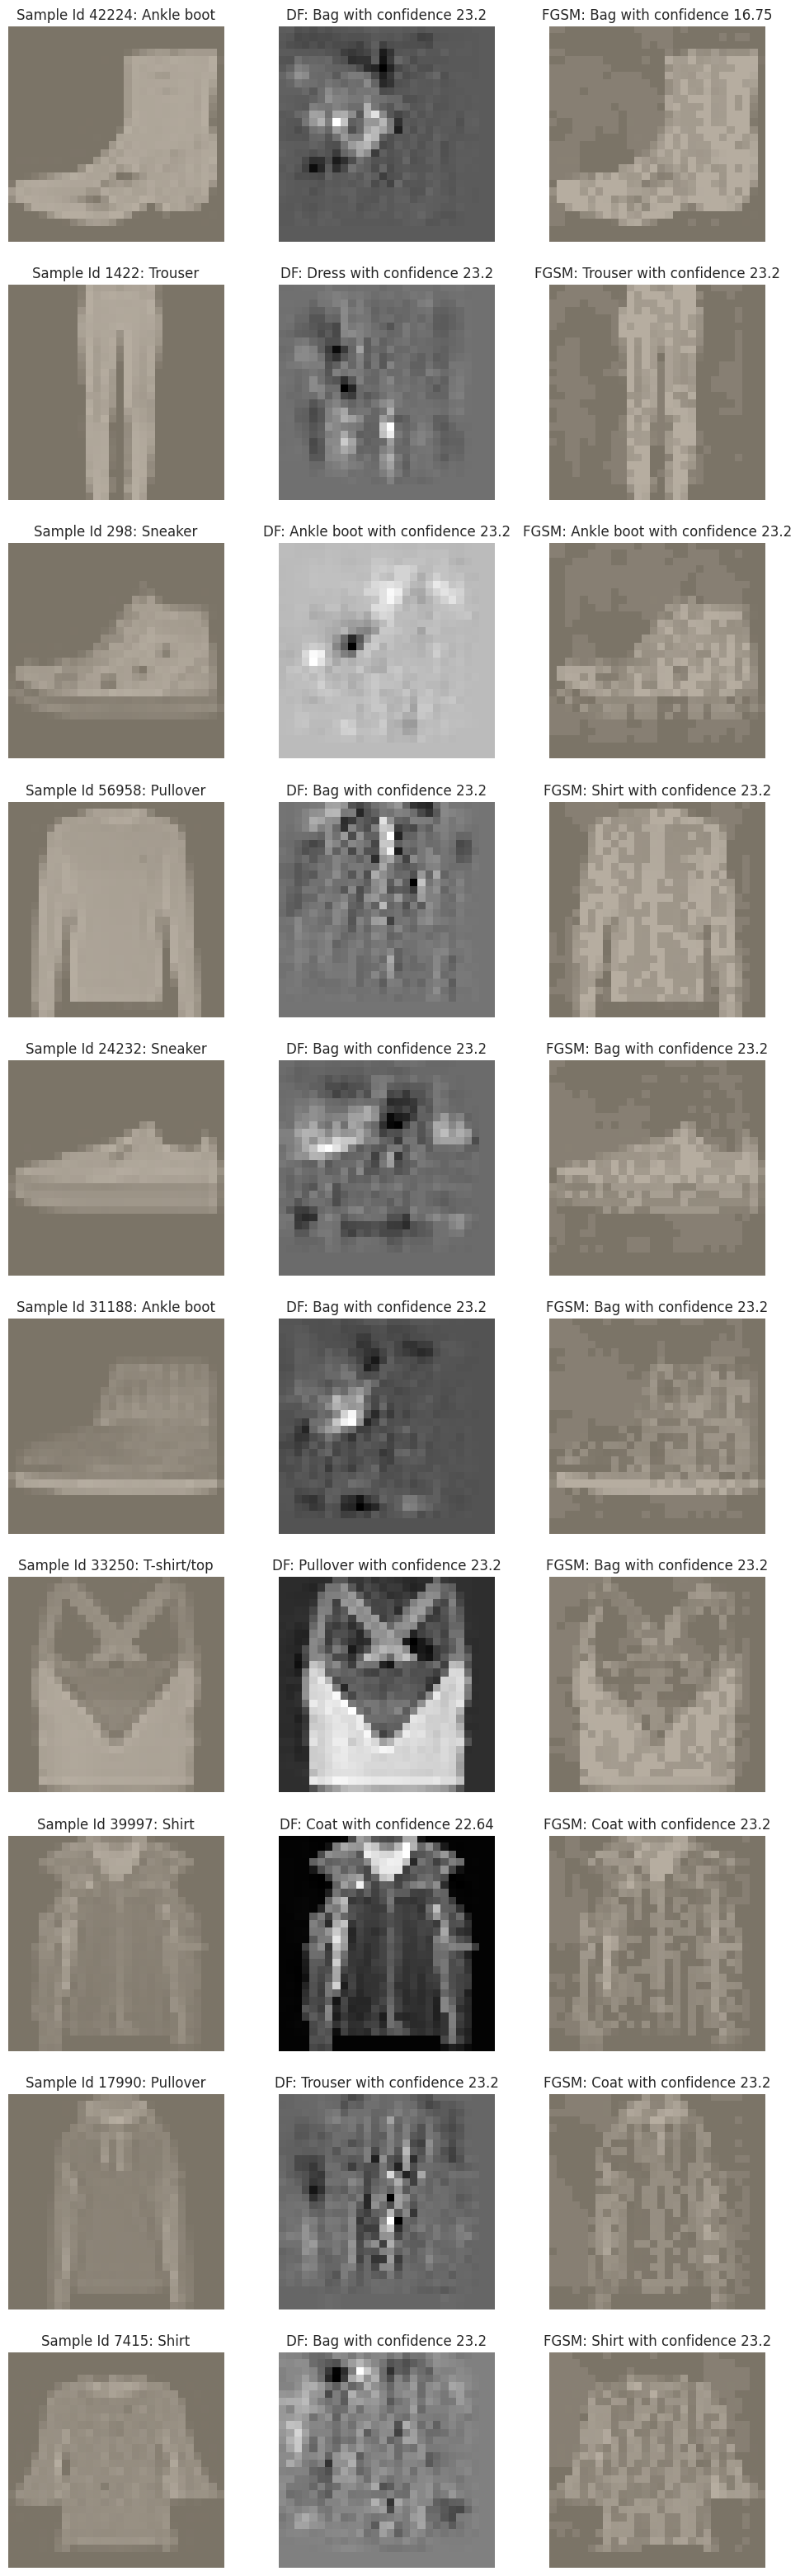

In [17]:
#untargeted attack for 10 random samples
sample = random.sample(range(len(training_data)),k=10)
subset = torch.utils.data.Subset(training_data, sample)
sample_loader = DataLoader(subset , batch_size=1,shuffle=True, num_workers=2) 
n_rows, n_cols = 10,3
i,j,counter=0,0,0
image_figure, image_axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
for image , label in sample_loader:
   j=0
   sample_id = sample[i]
   img = tensor_to_image(image)
   # Prepare figure. 
   # Show original image.
   ax = image_axes[i][j]
   ax.imshow(img)
   ax.grid(False)
   ax.axis('off')
   ax.set_title(f'Sample Id {sample_id}: {label_names[int(label[0])]}')
  
   j=1
   img, predict0, predict1 = deep_fool_untargeted_attack(model, image,label)
   top_idx = int(np.argmax(predict1))
   top_value = predict1.numpy()[0][top_idx]*100

   #img = tensor_to_image(img)
   # Prepare figure. 
   # Show original image.
   ax = image_axes[i][j]
   ax.imshow(img[0,0]*255,cmap='gray')
   ax.grid(False)
   ax.axis('off')
   ax.set_title(f'DF: {label_names[top_idx]} with confidence {round(top_value,2)}')

   j=2
   img, predict0, predict1 = fgsm_untargeted(model,image,label)
   top_idx = int(np.argmax(predict1))
   top_value = predict1.numpy()[0][top_idx]*100
   img = tensor_to_image(img)

   # Prepare figure. 
   # Show original image.
   ax = image_axes[i][j]
   ax.imshow(img)
   ax.grid(False)
   ax.axis('off')
   ax.set_title(f'FGSM: {label_names[top_idx]} with confidence {round(top_value,2)}')

   i+=1
   
   

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 0.01024
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 0.02048
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 0.04096
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 0.08192
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 0.16384
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 0.32768
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 0.65536
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 1.31072
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 2.62144
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 5.24288
finish optimization
label  tensor([[3]])
target label  6
in lbfgs_b: c = 10.48576
finish optimization
label  tensor([[3]])


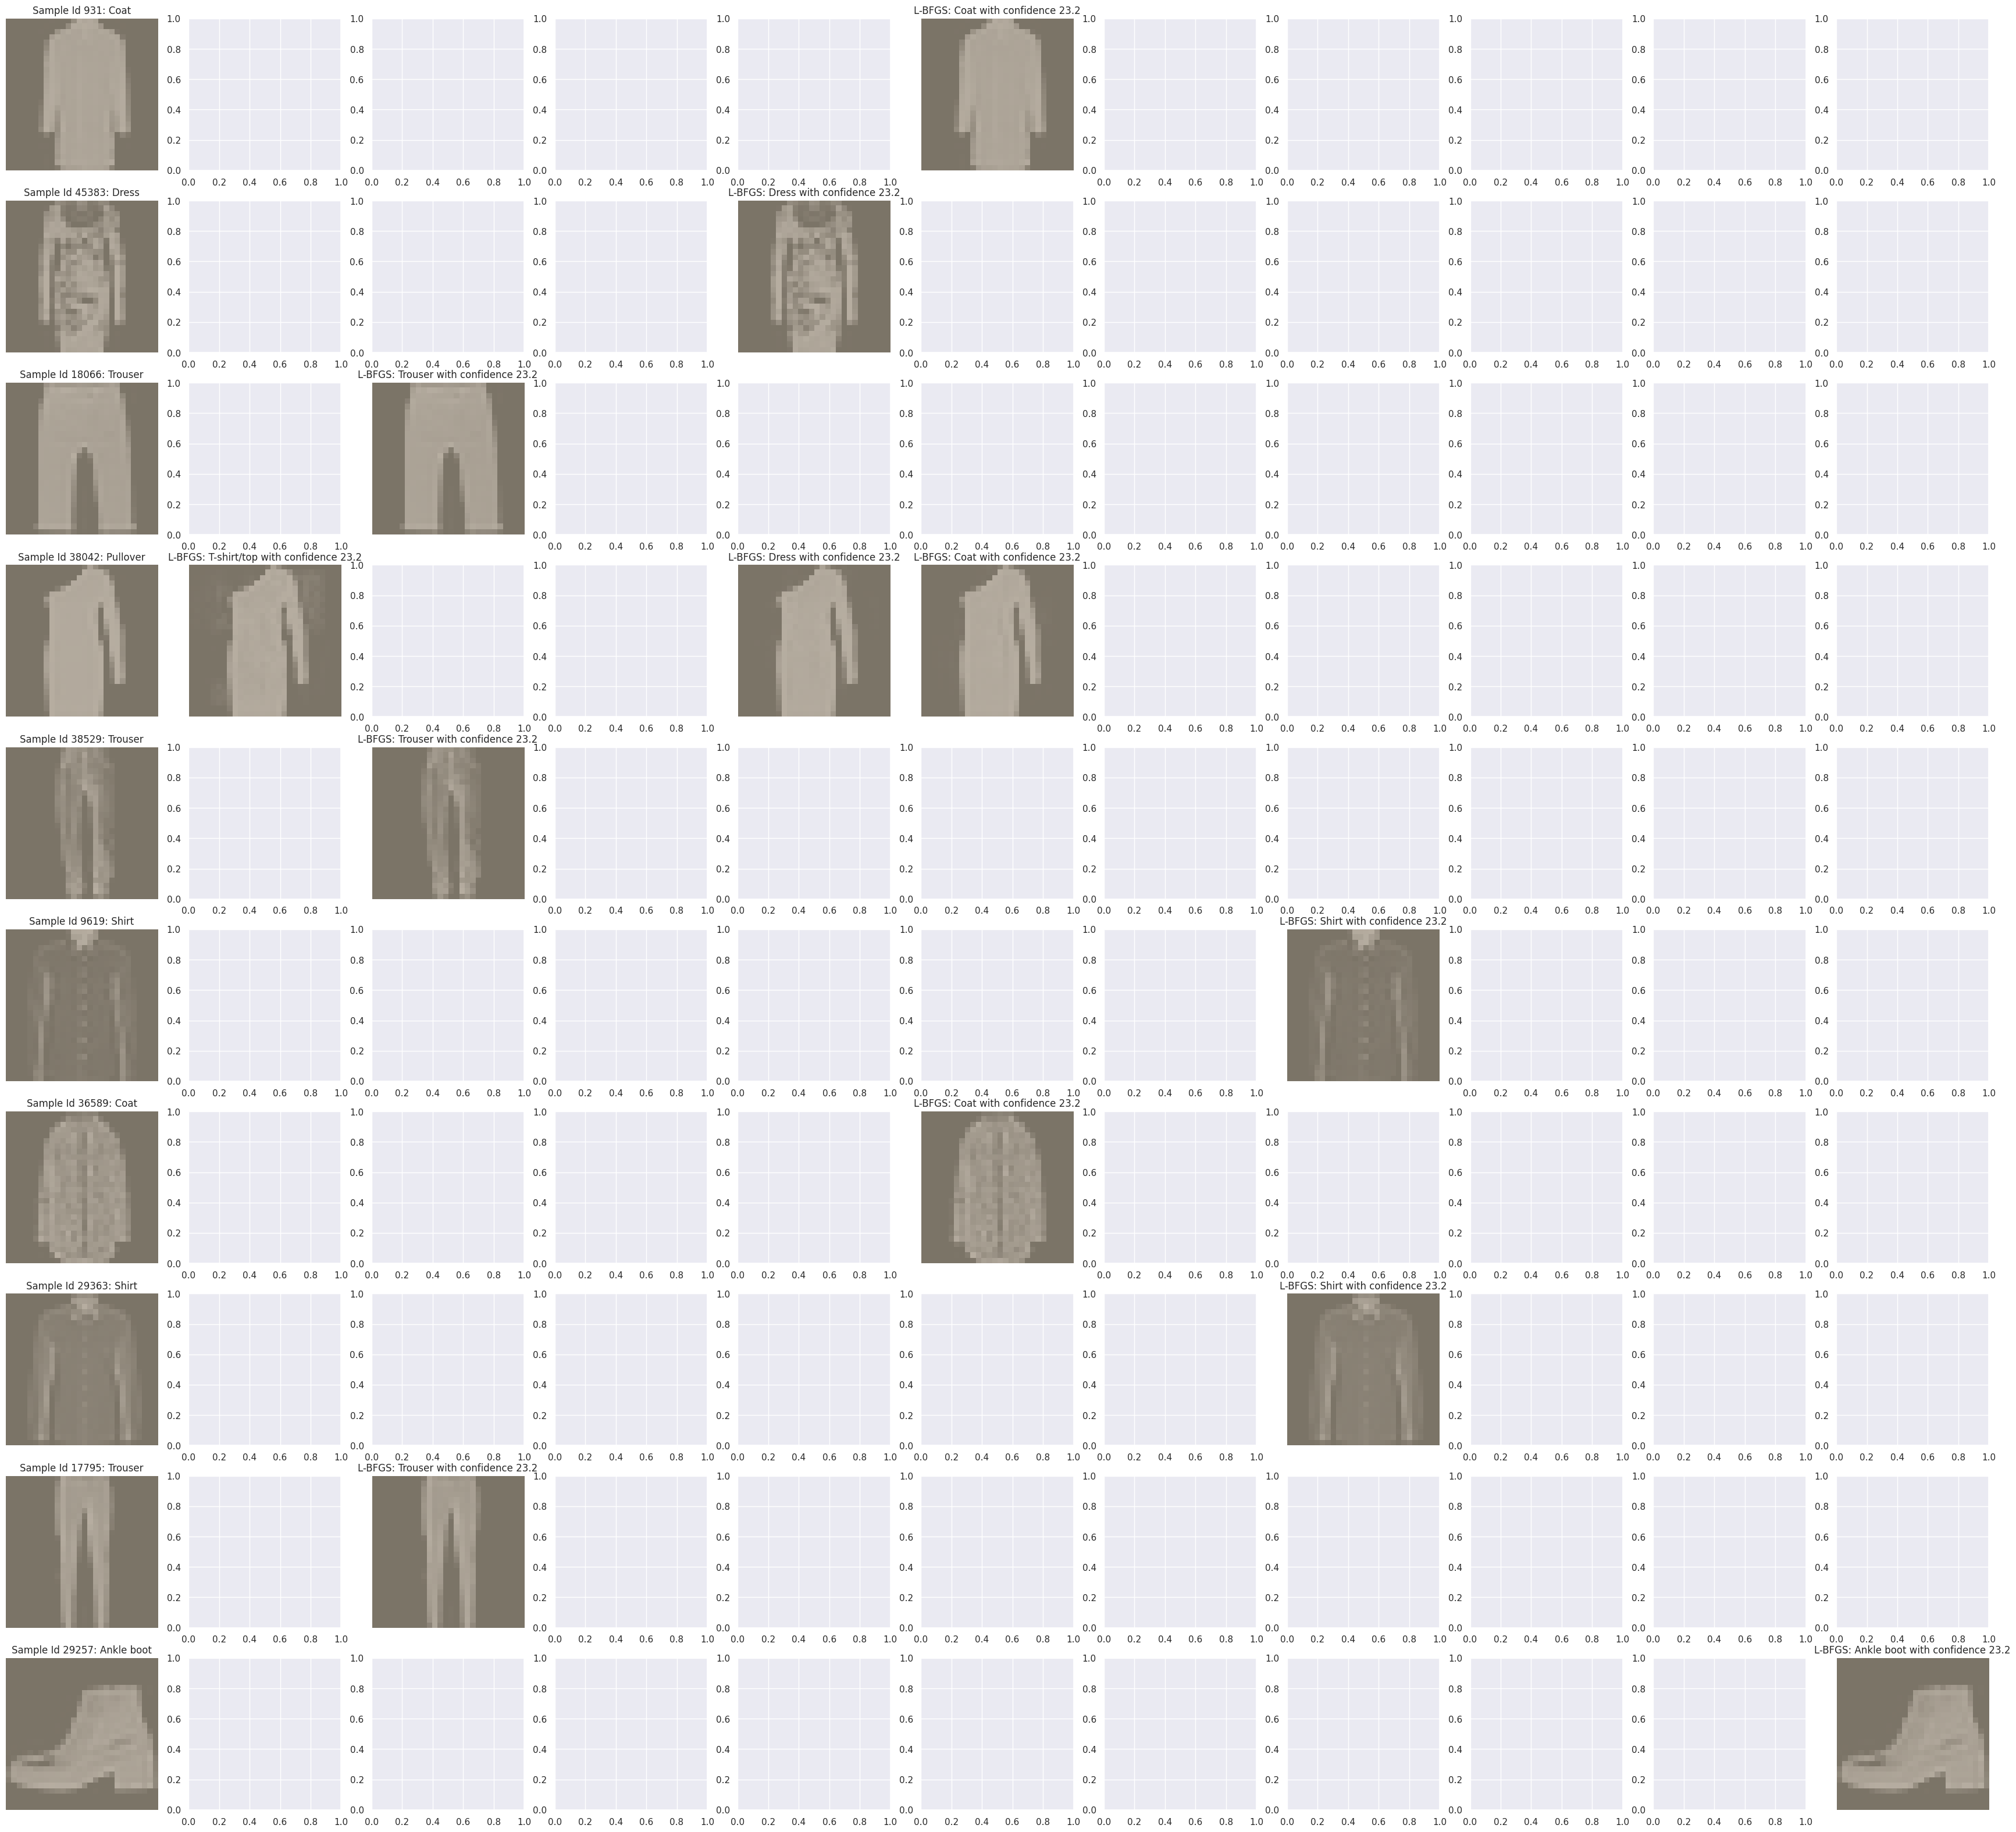

In [18]:
#Targeted Attack with L-BFGS for 10 sample of each class for one similiar and one different class
sample = random.sample(range(len(training_data)),k=10)
subset = torch.utils.data.Subset(training_data, sample)
sample_loader = DataLoader(subset , batch_size=1,shuffle=True, num_workers=2) 
sample_targets = {0:[6,7],1:[3,8],2:[4,7],3:[1,5],4:[3,9],5:[8,3],6:[0,7],7:[9,2],8:[0,1],9:[8,0]} #two targeted attack
n_rows, n_cols = 10,11
i,j,counter=0,0,0
image_figure, image_axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
for image , label in sample_loader:
   
   sample_id = sample[i] 
   img = tensor_to_image(image)
   #targets = sample_targets[int(label[0])]

   # Prepare figure. 
   # Show original image.
   ax = image_axes[i][0]
   ax.imshow(img)
   ax.grid(False)
   ax.axis('off')
   ax.set_title(f'Sample Id {sample_id}: {label_names[int(label[0])]}')
  
   for r in range(0,10):
    img, predict0, predict1 = lbfgs_target(model,image,label,r)
    print('predict ',predict1)
    
    if predict1!=None:
      top_idx = int(np.argmax(predict1))
      top_value = predict1.numpy()[0][top_idx]*100
      img = tensor_to_image(img)
      # Prepare figure. 
      # Show original image.
      ax = image_axes[i][r+1]
      ax.imshow(img,cmap='gray')
      ax.grid(False)
      ax.axis('off')
      ax.set_title(f'L-BFGS: {label_names[top_idx]} with confidence {round(top_value,2)}')
   i+=1
   